In [1]:
import sys
import os
# Add the directory containing 'thesis_utils.py' to the system path
sys.path.append(os.path.abspath('..'))  # If 'thesis_utils.py' is one level up
# Or use this if it's in the same directory as the notebook:
# sys.path.append(os.getcwd())
# os.environ["JULIA_NUM_THREADS"] = "8" 
os.environ["PYTHON_JULIACALL_HANDLE_SIGNALS"] = "yes"
os.environ["PYTHON_JULIACALL_THREADS"] = "auto"
os.environ["PYTHON_JULIACALL_OPTLEVEL"] = "3"
from pysr import PySRRegressor
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport

from thesis_utils import *

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [22]:
import importlib
import thesis_utils  # or whatever your module is called

importlib.reload(thesis_utils)

from thesis_utils import *

In [2]:
data = pd.read_csv("C:/Users/svenl/vs_code_projects/hyperRealDataDescriber/data/insurance/insurance_original.csv")
# encode categorical column 'smoker' with only two categories to numerical representation as this one is highly correlated with 'charges' column
data['smoker'] = data['smoker'].map({'yes': 1, 'no': 0})

In [3]:
# Generate the profiling report
profile_full = ProfileReport(data, title="Insurance Original", explorative=True)

# Get the description object
desc_full = profile_full.get_description()

# Access the correlation matrix
correlation_matrix = desc_full.correlations["auto"]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
categorical_cols = get_categorical_columns(data)
distributions = fit_distributions(data)
marginals = convert_distfit_to_marginals(distributions, data)

In [ ]:
data_syn = generate_synthetic_dataset(original_data=data, correlation_matrix=correlation_matrix, categorical_columns=categorical_cols, marginals=marginals, n_rows=2000, correlation_threshold=0.1, edge_strategy="random", sampling_strategy="local-chunks")

In [6]:
# Generate the profiling report
profile_syn = ProfileReport(data_syn, title="Insurance SYN", explorative=True)

# Get the description object
desc_syn = profile_syn.get_description()

# Access the correlation matrix
correlation_matrix_syn = desc_syn.correlations["auto"]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [23]:
plot_correlation_matrices(correlation_matrix, correlation_matrix_syn, "Real", "Synthetic")

In [8]:
from sdmetrics.reports.single_table import QualityReport

data_syn = data_syn[data.columns.to_list()]

metadata = {
    "columns": {
        "age": {"sdtype": "numerical"},
        "sex": {"sdtype": "categorical"},
        "bmi": {"sdtype": "numerical"},
        "children": {"sdtype": "numerical"},
        "smoker": {"sdtype": "numerical"},
        "region": {"sdtype": "categorical"},
        "charges": {"sdtype": "numerical"},
    }
}

report = QualityReport()
report.generate(data, data_syn, metadata)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 7/7 [00:00<00:00, 224.36it/s]|
Column Shapes Score: 90.71%

(2/2) Evaluating Column Pair Trends: |██████████| 21/21 [00:00<00:00, 188.76it/s]|
Column Pair Trends Score: 87.58%

Overall Score (Average): 89.15%



In [9]:
# variable assignment according to correlation structure
independents_lst = ['age', 'smoker']
dependent_var = 'charges'
X = data_syn[independents_lst].to_numpy()
y = data_syn[dependent_var].to_numpy()

In [10]:
sr_model = PySRRegressor(
        niterations=1024,  # Number of iterations to search for equations
        binary_operators=["+", "-", "*", "/"],
        unary_operators=["sin", "cos", "exp", "log", "abs", "sqrt"],
        elementwise_loss="loss(x, y) = (x - y)^2",  # Define loss function (mean squared error)
        verbosity=0,
        maxsize=50
    )
sr_model.fit(X, y)

PySRRegressor.equations_ = [
	    pick         score                                           equation  \
	0         0.000000e+00                                          12991.308   
	1   >>>>  5.353253e-02                                     x0 * 329.18478   
	2         5.591984e-04                              (x1 + x0) * 329.27396   
	3         4.034877e-02                         x0 * (exp(x1) * 326.57578)   
	4         5.465722e-03                 (x1 * 26843.375) + (x0 * 324.9717)   
	5         7.513716e-05              (x0 + exp(x1 / 0.22489586)) * 317.554   
	6         5.750509e-08   ((x1 * 26810.387) + (x0 * 317.23636)) + 329.4409   
	7         1.475965e-06       (317.52643 - x1) * (exp(x1 * 4.450952) + x0)   
	8         5.061455e-03   x0 * (((x1 * (62.50118 - x0)) * x0) + 324.89188)   
	9         3.185146e-04  x0 * (((-295.3207 - ((x0 + -68.76322) * x0)) *...   
	10        5.420390e-03  ((x1 * ((34.40177 / cos(x0 + 1.2261947)) + 793...   
	11        7.850060e-06  (x0 * (((x0 / cos(x0 + 1.2010981)) + 794.9914)...   
	12        7.233450e-04  x0 * (((exp(x1 * 3.5001252) / cos(x0 + 1.22766...   
	13        1.900928e-05  ((exp(x1 * 3.500125) / sin(cos(x0 + 1.2276212)...   
	14        8.942324e-04  (338.1055 - ((2.7318275 / sin(sqrt(x0 + ((x1 /...   
	15        8.843817e-05  (338.1055 - ((2.7318275 / sin(sin(sqrt((x0 + (...   
	16        7.059412e-04  (339.09122 - ((x1 * -853.7094) + (2.6382284 / ...   
	17        1.208565e-05  (339.09122 - ((x1 * -853.7094) + (2.6382284 / ...   
	18        8.104412e-04  ((x1 * ((x0 / cos(1.2003562 + x0)) + 792.40765...   
	19        4.861546e-08  (x0 * (x1 * ((x0 / cos(x0 + 1.2004262)) + 792....   
	20        8.172681e-04  (x0 * ((331.9861 + (((x1 * x0) + 1.4752414) / ...   
	21        2.389972e-05  (x0 * (331.9861 + ((((x1 * x0) + 1.4752414) / ...   
	22        1.054876e-05  (((x1 * x0) * 793.7739) - (135.32413 / sin(sqr...   
	23        1.225839e-04  abs((((((x1 * x0) + 1.5233208) / cos(x0 + 1.21...   
	24        7.001856e-05  (((x1 * x0) * 814.9678) + (((((x1 * (0.7715429...   
	25        2.073204e-05  ((x1 * (x0 * 814.9678)) + ((((((x0 * x1) * 0.7...   
	26        1.323758e-05  ((x1 * (x0 * 814.9678)) + (((((x0 * (x1 * 0.77...   
	27        1.275107e-05  ((x0 * ((((x1 * x0) + 1.991998) * (0.80045974 ...   
	28        2.155066e-05  ((x0 * ((((x0 * x1) + 1.991998) * (0.80045974 ...   
	29        8.464886e-04  ((x0 / cos((x0 + x0) + 0.6461762)) + ((x0 * (x...   
	30        6.118263e-05  (x0 * ((x0 * (x1 / cos(x0 + 1.2017658))) + ((2...   
	31        1.189265e-03  ((((((x0 * x1) + 1.8567673) / cos(x0 + 1.20013...   
	32        6.886594e-06  ((((1.8567673 + (x0 * x1)) / cos(1.2001321 + x...   
	33        3.357058e-04  (x0 * ((((x0 * x1) + 1.7940953) / cos(x0 + 1.1...   
	34        1.170930e-05  (x0 * ((((x0 * x1) + 1.7942129) / cos(x0 + 1.1...   
	35        2.436235e-04  (x0 / cos(x0 + (x0 + 0.6507128))) + ((((x0 * 7...   
	36        1.983289e-05  ((((x0 * 792.5185) * x1) - ((x0 + 77.66153) / ...   
	37        1.253240e-05  ((((x1 * x0) * 792.5185) - ((x0 + 77.66153) / ...   
	38        5.007261e-05  (x0 / cos((x0 + x0) + 0.650533)) + ((x0 * ((((...   
	39        1.752251e-04  (x0 / cos(x0 + (0.65063775 + x0))) + (((x1 * (...   
	40        3.835914e-04  ((((((x1 * x0) + 1.7939535) / cos(x0 + 1.19972...   
	41        1.343872e-05  ((((((x1 * x0) + 1.7939535) / cos(x0 + 1.19972...   
	42        5.010378e-05  (((((x1 * x0) * 792.2047) - (x0 / sin(x0 + 5.0...   
	43        2.949697e-05  ((x1 * ((cos(x0) + x0) * 792.2047)) + ((x0 * (...   
	44        2.525869e-05  (((((x1 * x0) * 792.2047) - (x0 / sin(x0 + 5.0...   
	
	           loss  complexity  
	0   121718910.0           1  
	1   109360450.0           3  
	2   109238210.0           5  
	3   104918320.0           6  
	4   104346430.0           7  
	5   104338590.0           8  
	6   104338584.0           9  
	7   104338430.0          10  
	8   103811660.0          11  
	9   103745550.0          13  
	10  103184730.0          14  
	11  1031

In [16]:
# 20250423_170609_AWjGBJ
candidate_function = generate_candidate_function("(338.1055 - ((2.7318275 / sin(sqrt(x0 + ((x1 / 0.28943098) + 25.32232)))) + (-853.7094 * x1))) * x0")

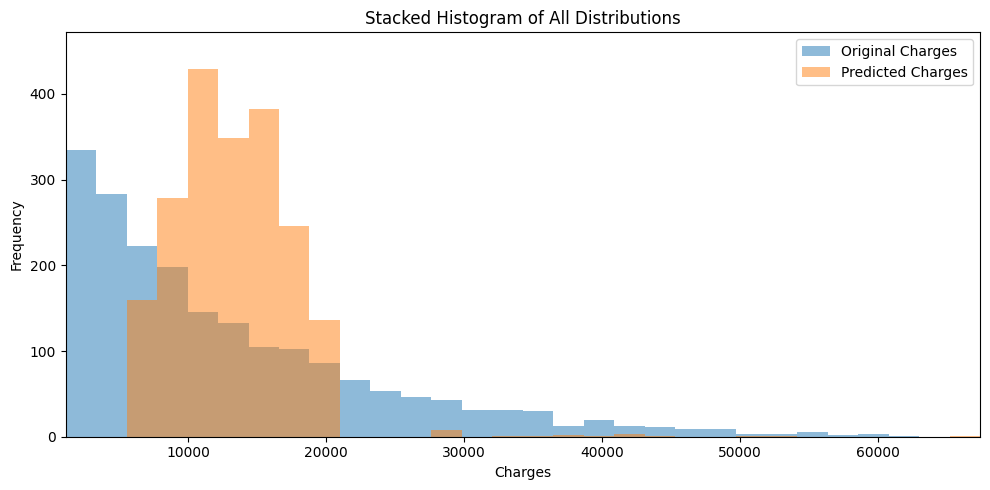

In [24]:
%matplotlib inline
y_pred = candidate_function(X)
plot_histograms([(y, 'Original Charges', None), (y_pred, 'Predicted Charges', None)], 'Charges', stack=True, figsize_per_plot=(10, 5))

<Figure size 640x480 with 0 Axes>

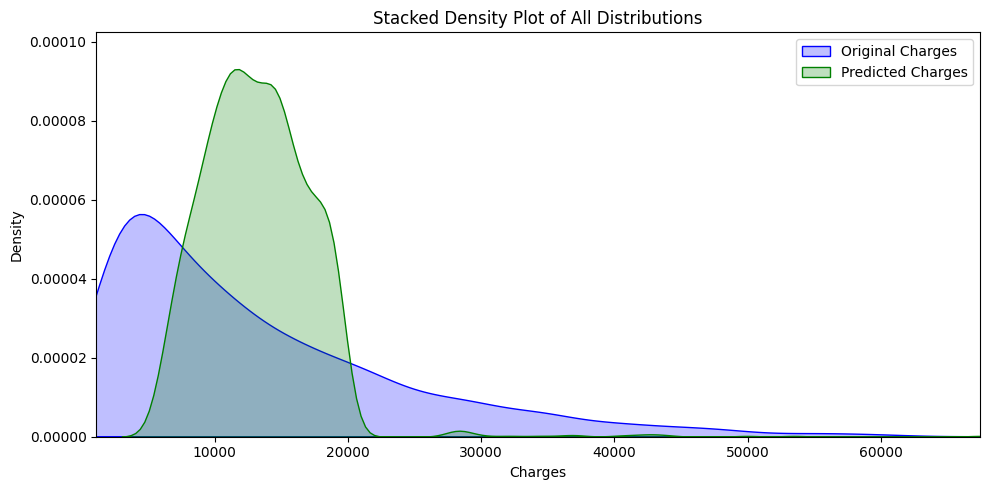

In [29]:
plot_densities([(y, 'Original Charges', 'blue'), (y_pred, 'Predicted Charges', 'green')], 'Charges', stack=True, figsize_per_plot=(10, 5))

In [31]:
orig_residuals = y - y_pred

In [19]:
y_pred_corrected, best_amp, errors, _ = renoise_predictions(y, y_pred, method='stratified', seed=42, clip_lower=0, clip_upper=None, original_residuals=None, tail_replace=True, lower_percentile=50)
# ignore error in orig_residuals after first run

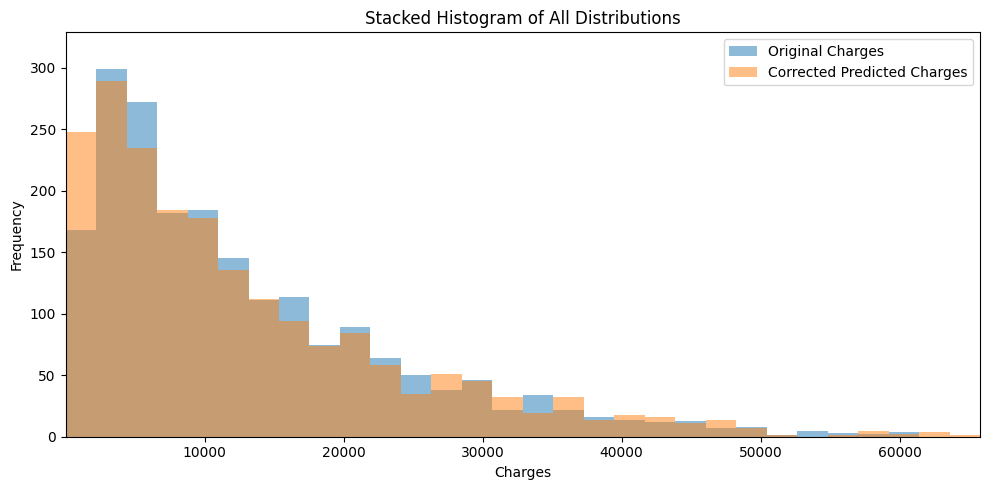

In [27]:
plot_histograms([(y, 'Original Charges', None), (y_pred_corrected, 'Corrected Predicted Charges', None)], 'Charges', stack=True, figsize_per_plot=(10, 5))

<Figure size 640x480 with 0 Axes>

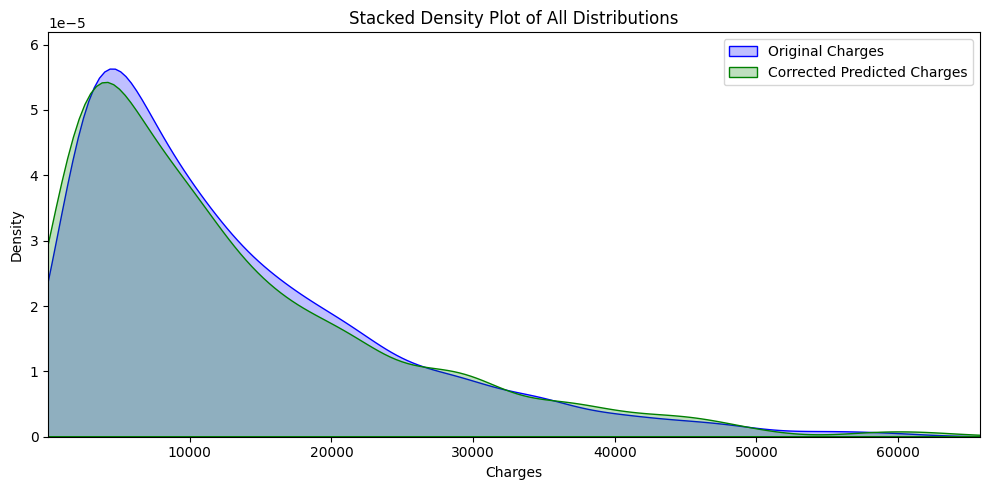

In [28]:
plot_densities([(y, 'Original Charges', 'blue'), (y_pred_corrected, 'Corrected Predicted Charges', 'green')], 'Charges', stack=True, figsize_per_plot=(10, 5))

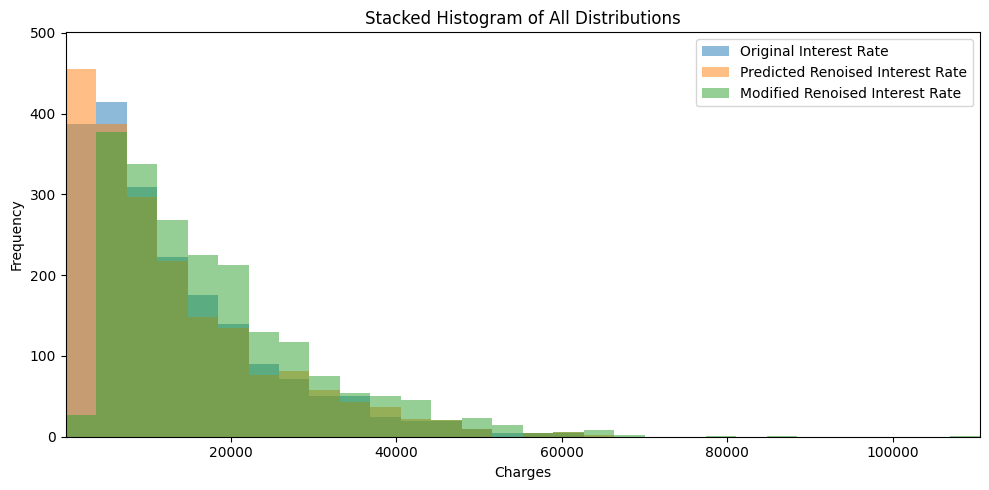

In [36]:
mod_candidate_function = generate_candidate_function("(338.1055 - ((2.7318275 / sin(sqrt(1.3*x0 + ((x1 / 0.28943098) + 25.32232)))) + (-853.7094 * x1))) * 1.3*x0")
mod_y_pred = mod_candidate_function(X)
mod_y_pred_corrected, best_amp, errors, _ = renoise_predictions(y, mod_y_pred, method='stratified', amplification_factor=1.0, seed=42, clip_lower=0, clip_upper=None, original_residuals=orig_residuals, tail_replace=True, lower_percentile=50)
# ignore error in orig_residuals after first run
plot_histograms([(y, 'Original Interest Rate', None), (y_pred_corrected, 'Predicted Renoised Interest Rate', None), (mod_y_pred_corrected, 'Modified Renoised Interest Rate', None)], 'Charges', stack=True, figsize_per_plot=(10, 5))